# The Zangellini Similarity

In [1]:
# Imports
import numpy as np
from matplotlib import pyplot as plt
from quantum_systems import OneDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccsd import TDCCSD
from coupled_cluster.integrators import GaussIntegrator
from tdhf import HartreeFock

In [2]:
# Major Lazer
class LaserPulse:
    def __init__(self, laser_frequency=2, laser_strength=1):
        self.laser_frequency = laser_frequency
        self.laser_strength = laser_strength

    def __call__(self, t):
        return self.laser_strength * np.sin(self.laser_frequency * t)

In [3]:
# The Zanghellini system
n = 2
l = 6
length = 10
num_grid_points = 400
omega = 0.25
laser_frequency = 8 * omega
laser_strength = 1

zanghellini = OneDimensionalHarmonicOscillator(
    n, l, length, num_grid_points, omega=omega
)
zanghellini.setup_system()
major_laser = LaserField(
    LaserPulse(
        laser_frequency=laser_frequency, laser_strength=laser_strength
    )
)

zanghellini.set_time_evolution_operator(major_laser)

In [4]:
hf_zanghellini = HartreeFock(zanghellini, verbose=True)
C = hf_zanghellini.scf(tolerance=1e-6)
zanghellini.change_basis(C)

HF converged to given precision in 16 iterations
Ehf: (1.1910077286632412+0j)


In [5]:
tdccsd_zanghellini = TDCCSD(zanghellini, np=np, verbose=True)
tdccsd_zanghellini.compute_ground_state()
print(f"HF->CCSD ground state energy: {tdccsd_zanghellini.compute_ground_state_energy().real:8.7}")

Iteration: 0	Residuals (t): [0.10809284285626265, 0.14518168995958008]
Iteration: 1	Residuals (t): [0.021712122247475547, 0.05420627842641132]
Iteration: 2	Residuals (t): [0.007530080992619439, 0.022820550173323084]
Iteration: 3	Residuals (t): [0.0007552561265227088, 0.008371723639395881]
Iteration: 4	Residuals (t): [0.0004636413280843983, 0.0033377745812383625]
Iteration: 5	Residuals (t): [6.158010907051116e-05, 0.0012986008640555658]
Iteration: 6	Residuals (t): [3.41473842206973e-05, 0.0005180466171993282]
Iteration: 7	Residuals (t): [1.7583697073264153e-05, 0.00020791829042539085]
Iteration: 8	Residuals (t): [4.480221101126967e-06, 8.307664074654046e-05]
Iteration: 0	Residuals (l): [0.09900601905905533, 0.45644502665388614]
Iteration: 1	Residuals (l): [0.06772491708719953, 0.0707844549727992]
Iteration: 2	Residuals (l): [0.028467909730735846, 0.018322961424663827]
Iteration: 3	Residuals (l): [0.008923686750348055, 0.003059179114199269]
Iteration: 4	Residuals (l): [0.0027400066369900

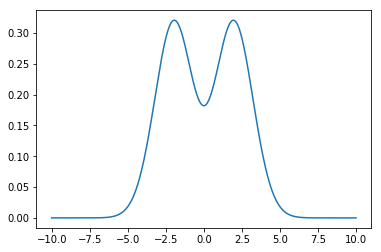

In [6]:
rho = tdccsd_zanghellini.compute_ground_state_particle_density()
plt.plot(zanghellini.grid, rho.real)
plt.show()

In [7]:
tdccsd_zanghellini.set_initial_conditions()

In [9]:
num_time_steps = 1001
time_points = np.linspace(0, 10, num_time_steps)
psi_overlap = np.zeros(num_time_steps)
td_energies = np.zeros(num_time_steps)

psi_overlap[0] = tdccsd_zanghellini.compute_time_dependent_overlap().real
td_energies[0] = tdccsd_zanghellini.compute_energy().real

In [ ]:
for 